In [1]:
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 42

In [2]:
train = pd.read_parquet("train_temporal_regression.parquet.gz")
test = pd.read_parquet("test_temporal_regression.parquet.gz")

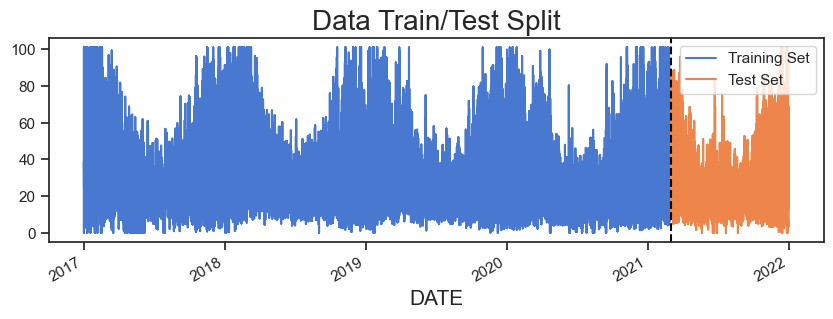

In [3]:
#Visualizing how the data is split
cut_off_date="2021-03-01"

fig, ax = plt.subplots(figsize=(10, 3))

train.plot(y='CAQI_idx', ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(y='CAQI_idx', ax=ax, label='Test Set')

ax.axvline(cut_off_date, color='black', ls='--')

ax.legend(['Training Set', 'Test Set'])
plt.show();

In [4]:
X_train = train.drop('CAQI_idx', axis=1)
y_train = train['CAQI_idx']

X_test = test.drop('CAQI_idx', axis=1)
y_test = test['CAQI_idx']

In [5]:
unpkl_encoders = open("encoders.pkl", "rb")
encoders = pickle.load(unpkl_encoders)

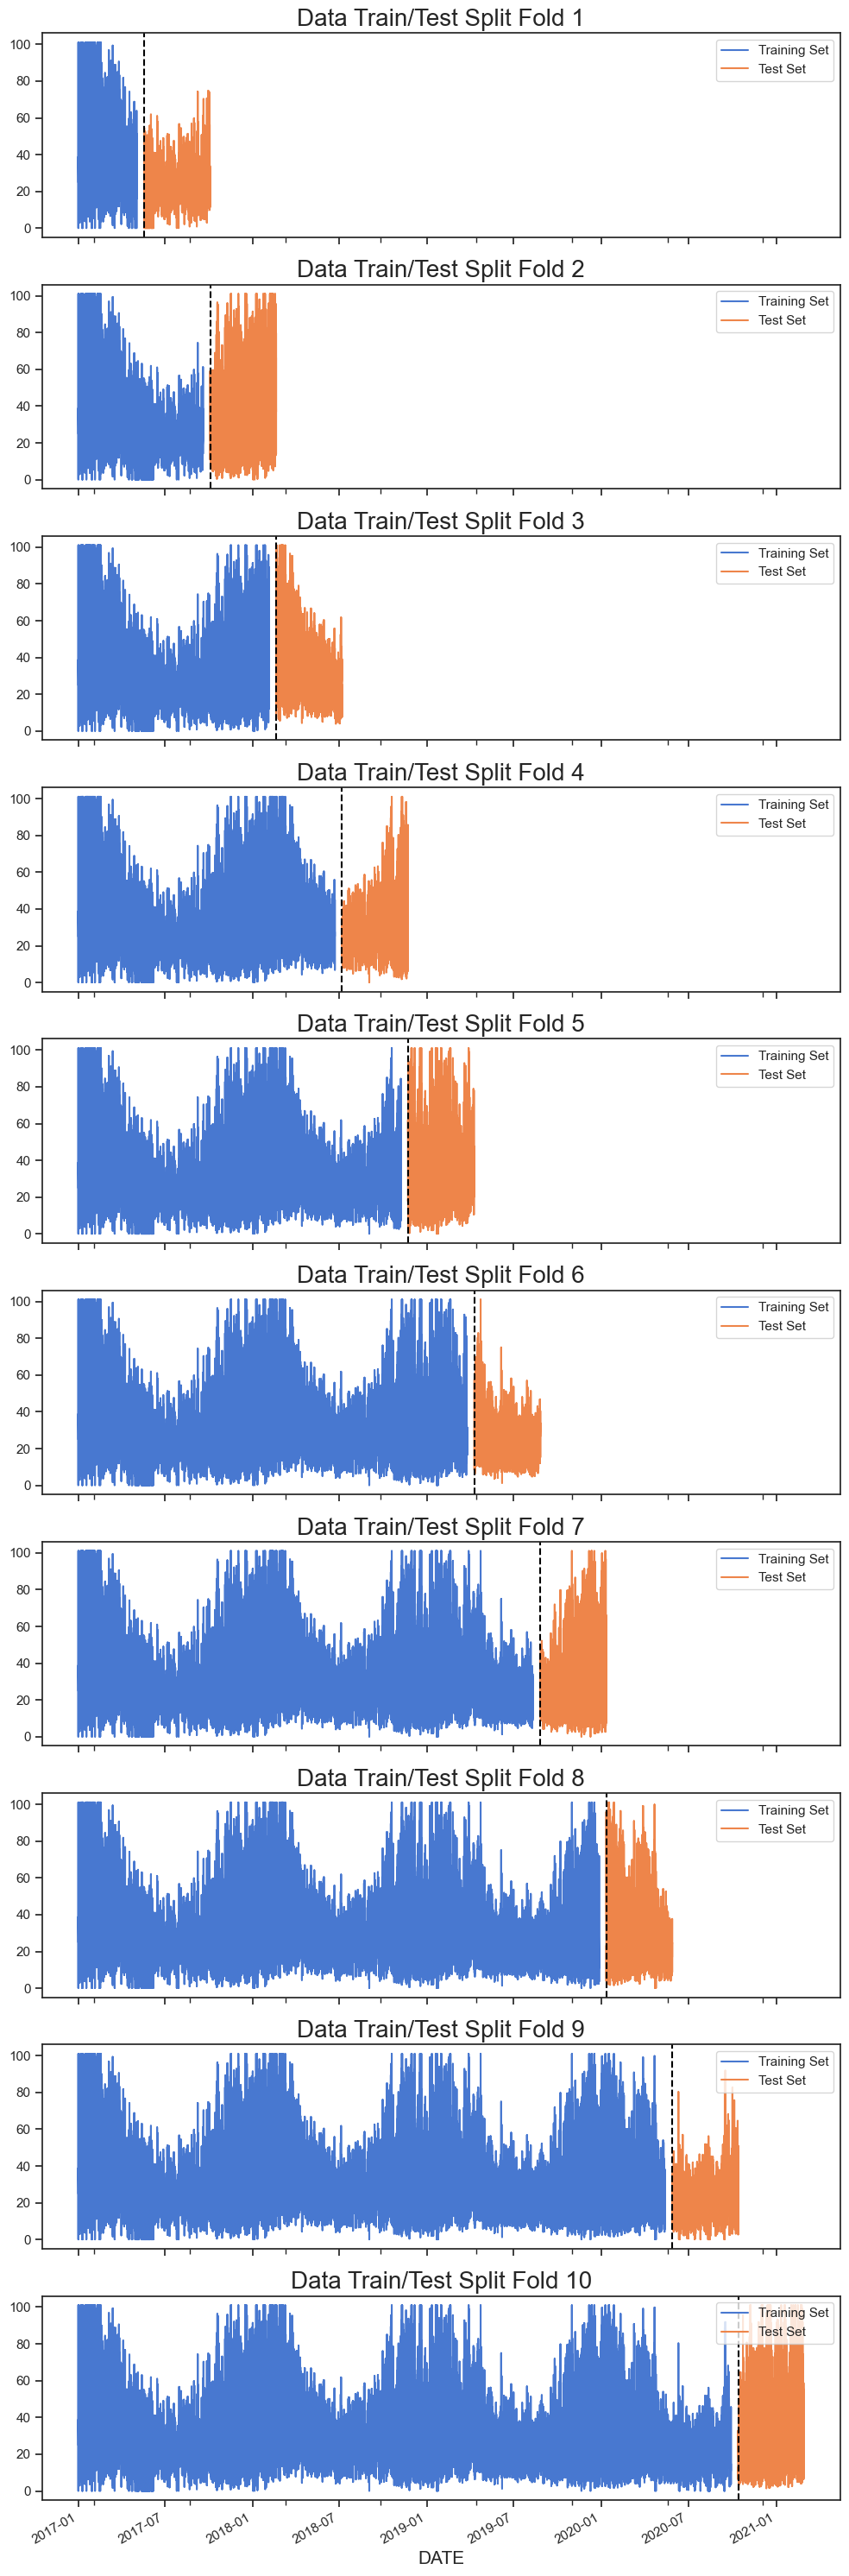

In [6]:
#Visualizing how the cross validation will be done
n_split = 10

max_train_size=None
test_size=None

# max_train_size=198*638
# test_size=198*90

tss = TimeSeriesSplit(
    n_splits=n_split, 
    max_train_size=max_train_size, 
    test_size=test_size, 
    gap=198*15
)

fig, axs = plt.subplots(n_split, 1, figsize=(10, n_split*3), sharex=True, tight_layout=True)

fold = 0
for train_idx, val_idx in tss.split(train):
    train_cv = train.iloc[train_idx]
    test_cv = train.iloc[val_idx]
    
    train_cv.plot(y='CAQI_idx', ax=axs[fold], label='Training Set',
                  title=f'Data Train/Test Split Fold {fold + 1}')
    
    test_cv.plot(y='CAQI_idx', ax=axs[fold], label='Test Set')
    
    axs[fold].axvline(test_cv.index.min(), color='black', ls='--')
    
    fold += 1

In [7]:
def cross_validate_and_test(cv, pipeline, X_train, y_train, X_test, y_test):
    
    rmse_values = []

    count = 1
    # Loop through the folds
    print("Cross Validating.....")
    print()

    for train_index, test_index in cv.split(X_train, y_train):

        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # Fit the model on the train data
        pipeline.fit(X_train_cv, y_train_cv)

        # Predict on the test data
        y_pred = pipeline.predict(X_test_cv)

        # Calculate the mean squared error
        rmse = mean_squared_error(y_test_cv, y_pred, squared=False)

        print(f"cv #{count}: RMSE = {rmse:.3f}")

        rmse_values.append(rmse)
        count += 1

    # Print the average MSE over all folds
    print()
    print(f"Average Train RMSE: {np.mean(rmse_values):.3f} ± {np.std(rmse_values):.2f}")


    #Predicting on Test set
    predictions = pipeline.predict(X_test)
    test_rmse = mean_squared_error(y_test, predictions, squared=False)

    print(f"Test RMSE Score: {test_rmse:.3f}")
    print()
    
    plot_cv_results(pipeline=pipeline)
    
    return predictions
    
    
def plot_cv_results(pipeline):
    
    feat_scores=pipeline.steps[-1][-1].feature_importances_
    feat_names=pipeline.steps[-1][-1].feature_names_in_

    #Creating a dataframe for feature importance
    feat_imp_df = \
    pd.DataFrame({
    #     'features' : encoders.fit_transform(X_train).columns,
        'features' : feat_names,
        'importance' : np.abs(np.round(feat_scores, 3))
    }).set_index('features').sort_values('importance')
    
    
    #Print Features with Low Importance
    print("Features with Low Importance:")
    print(np.sort(feat_imp_df.query("importance<=0.001").index))
    
    #Plot
    ax = feat_imp_df.plot(kind='barh', edgecolor='k', figsize=(3, 20))
    ax.bar_label(ax.containers[0], fontsize=13, padding=3);
    ax.legend().remove()
    ax.set_title("Feature Importance")
    
    plt.show();

In [8]:
def compare_actual_predicted_ts(predictions, X_test):
    
    test_df = pd.concat([X_test[['powiat_voivod', 'voivodship']], y_test], axis=1)
    test_df['predictions'] = predictions
    test_df['error'] = test_df['CAQI_idx'] - test_df['predictions']
    
    #Plot Actual Vs Predicted
    test_df.groupby(test_df.index)[['CAQI_idx', 'predictions']].mean().\
    plot(title='Actual vs Predicted CAQI', figsize=(10, 4));
    
    actual_predicted_scatterplot(test_df=test_df)
    plot_high_mean_CAQI_powiat(test_df=test_df)
    plot_low_mean_CAQI_powiat(test_df=test_df)
    
    
def actual_predicted_scatterplot(test_df):
    r2 = r2_score(test_df['CAQI_idx'], test_df['predictions'])

    fig, ax = plt.subplots(figsize=(8, 6))

    test_df.plot(x='predictions', y='CAQI_idx', kind='scatter', edgecolor='k', c='b', 
                 alpha=0.7, ax=ax, label=f"$r^2$ - {r2:.3f}");

    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='r', ls='--')  
    ax.legend(fontsize=15)
    ax.set_ylabel("Actual CAQI")
    ax.set_xlabel("Predicted CAQI");
    
    plt.show()
    
def plot_high_mean_CAQI_powiat(test_df):
    
    #Powiat with highest mean CAQI
    ax = test_df.query("powiat_voivod=='powiat wodzisławski, śląskie'").\
        plot(y=["CAQI_idx", "predictions"], figsize=(10, 3))

    ax.set_title("powiat wodzisławski, śląskie");
    
    plt.show()

def plot_low_mean_CAQI_powiat(test_df):
    #Powiat with lowest mean CAQI
    ax = test_df.query("powiat_voivod=='powiat krośnieński, podkarpackie'").\
        plot(y=["CAQI_idx", "predictions"], figsize=(10, 3))

    ax.set_title("powiat krośnieński, podkarpackie");
    
    plt.show()

In [9]:
# XGBoost
xgb=XGBRegressor(
    n_estimators=200,
    eta=0.435,
    booster='gblinear',
    n_jobs=-1, 
    random_state=seed,
    eval_metric="rmse"
)

#Putting whole pipeline together
pipeline = make_pipeline(
    (encoders), #Encoders
    (xgb) #XGBoost
)

print("Pipeline Created!")

Pipeline Created!


### Baseline Model Test RMSE Score - 8.355

Cross Validating.....

cv #1: RMSE = 12.544
cv #2: RMSE = 12.783
cv #3: RMSE = 8.736
cv #4: RMSE = 8.803
cv #5: RMSE = 12.725
cv #6: RMSE = 5.944
cv #7: RMSE = 10.264
cv #8: RMSE = 9.335
cv #9: RMSE = 5.722
cv #10: RMSE = 11.734

Average Train RMSE: 9.859 ± 2.50
Test RMSE Score: 8.345

Features with Low Importance:
['area by land - lands under waters' 'dayofweek_cos'
 'forest fires - area of forest fires, total' 'holiday_name_Easter Monday'
 'powiat_voivod' 'voivodship' 'wind_speed']


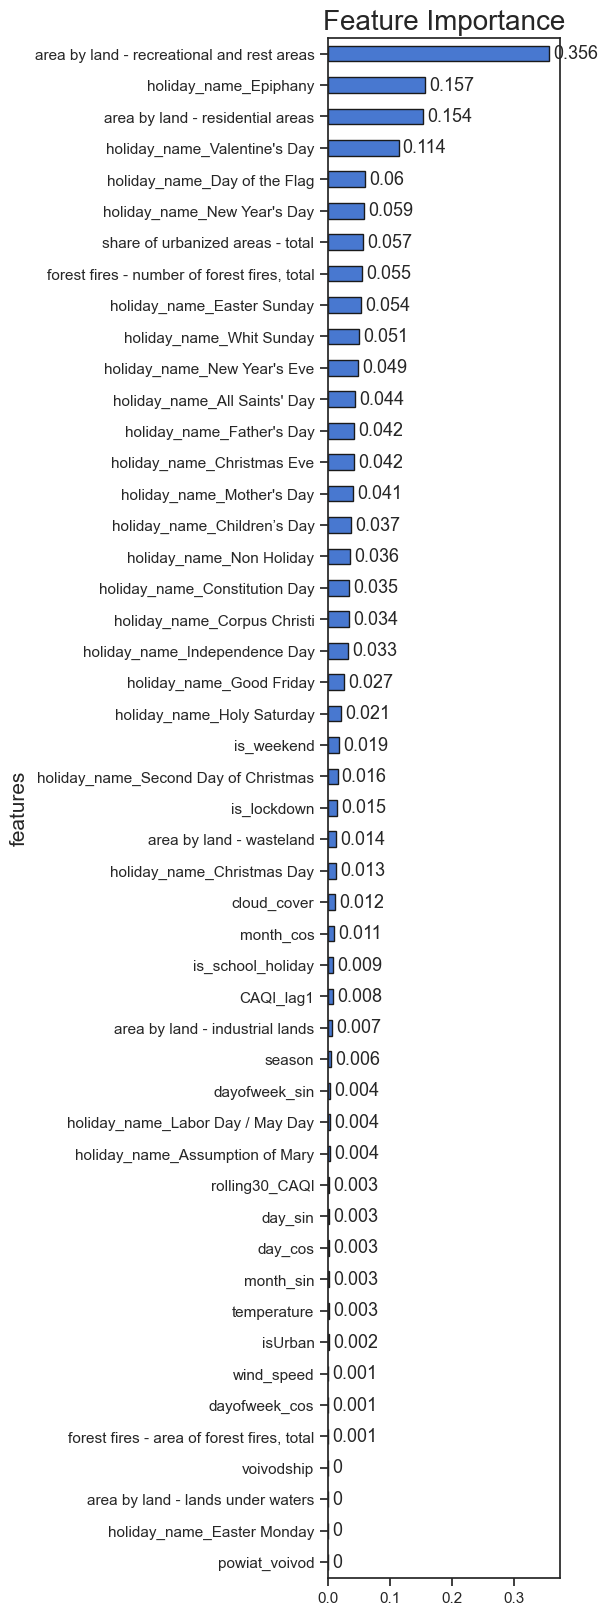

Wall time: 2min 25s


In [10]:
%%time
#Training the pipeline using Cross validation
predictions = cross_validate_and_test(cv=tss, 
                                      pipeline=pipeline, 
                                      X_train=X_train, 
                                      y_train=y_train, 
                                      X_test=X_test, 
                                      y_test=y_test)

### Tuned Model Test RMSE Score - 8.345

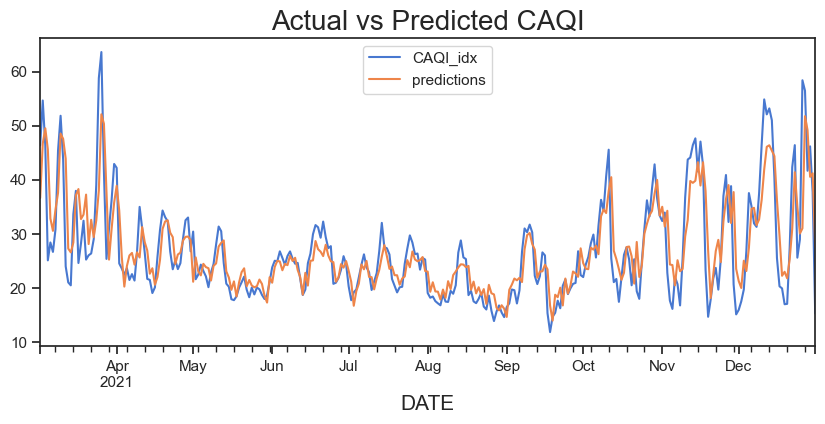

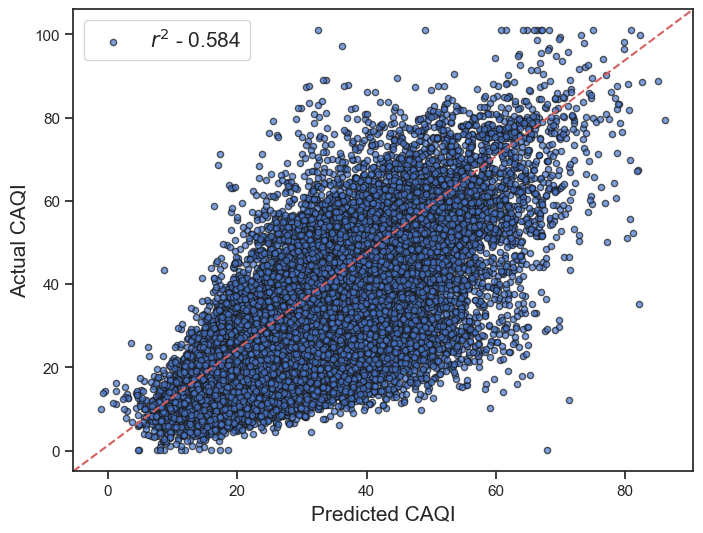

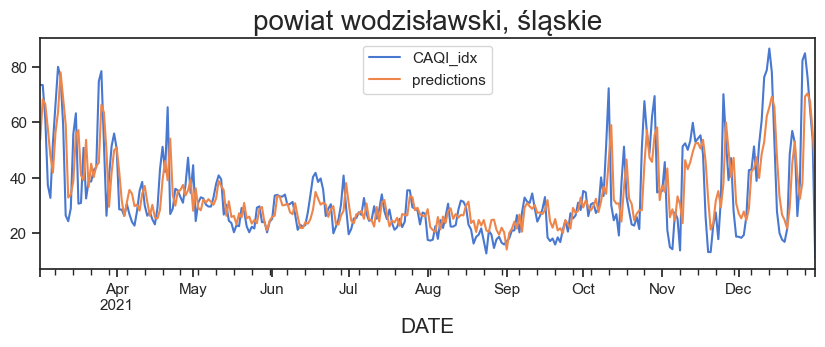

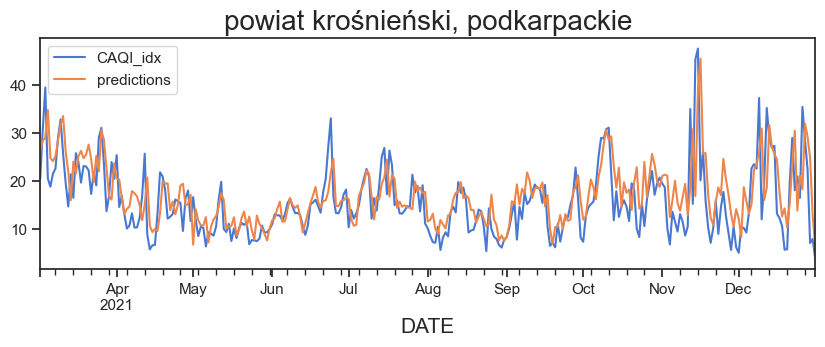

In [11]:
compare_actual_predicted_ts(predictions=predictions, X_test=X_test)